# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [3]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [4]:
# Get utils.py and create directories

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/code/soln/utils.py
        
if not os.path.exists('figs'):
    !mkdir figs

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf, Cdf
from utils import decorate, savefig

## Bayesian regression

This notebook presents a simple example of Bayesian regression using synthetic data

## More snow?

I am under the impression that we don't get as much snow around here as we used to.  By "around here" I mean Norfolk County, Massachusetts, where I was born, grew up, and currently reside.  And by "used to" I mean compared to when I was young, like in 1978 when we got [27 inches of snow](https://en.wikipedia.org/wiki/Northeastern_United_States_blizzard_of_1978) and I didn't have to go to school for a couple of weeks.

Fortunately, we can test my conjecture with data.  Norfolk County happens to be the location of the [Blue Hill Meteorological Observatory](https://en.wikipedia.org/wiki/Blue_Hill_Meteorological_Observatory), which keeps the oldest continuous weather record in North America.

Data from this and many other weather stations is available from the [National Oceanic and Atmospheric Administration](https://www.ncdc.noaa.gov/cdo-web/search) (NOAA).  I collected data from the Blue Hill Observatory from May 11, 1967 to May 11, 2020.  The following cell downloads the data as a CSV file.

In [88]:
import os

datafile = '2239075.csv'
if not os.path.exists(datafile):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/data/2239075.csv

--2020-08-14 14:53:07--  https://github.com/AllenDowney/ThinkBayes2/raw/master/data/2239075.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkBayes2/master/data/2239075.csv [following]
--2020-08-14 14:53:08--  https://raw.githubusercontent.com/AllenDowney/ThinkBayes2/master/data/2239075.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.116.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.116.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1853619 (1.8M) [text/plain]
Saving to: ‘2239075.csv’

2239075.csv         100%[===================>]   1.77M  2.05MB/s    in 0.9s    

2020-08-14 14:53:09 (2.05 MB/s) - ‘2239075.csv’ saved [1853619/1853619]



We can read the data into a Pandas `DataFrame`:

In [62]:
df = pd.read_csv('2239075.csv', parse_dates=[2])

Here's what the last few rows look like.

In [82]:
df.tail()

,STATION,NAME,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESD,...,WT03,WT04,WT05,WT06,WT08,WT09,WT11,WT16,WT18,year
19355,USC00190736,"BLUE HILL COOP, MA US",2020-05-07,0.00,0.0,0.0,57,37.0,43.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
19356,USC00190736,"BLUE HILL COOP, MA US",2020-05-08,0.00,0.0,0.0,63,42.0,45.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
19357,USC00190736,"BLUE HILL COOP, MA US",2020-05-09,0.45,0.0,0.0,57,34.0,34.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
19358,USC00190736,"BLUE HILL COOP, MA US",2020-05-10,0.00,0.0,0.0,44,31.0,38.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020
19359,USC00190736,"BLUE HILL COOP, MA US",2020-05-11,0.00,0.0,0.0,59,38.0,50.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020


I'll add a column that contains just the year part of the dates.

In [102]:
df['YEAR'] = df['DATE'].dt.year

And use `groupby` to add up the total snowfall in each year.

In [172]:
snow = df.groupby('YEAR')['SNOW'].sum()
len(snow)

54

The first and last years are not complete, so I'll drop them.

In [173]:
complete = snow.iloc[1:-1]
len(complete)

52

The following figure shows total snowfall during each of the complete years in my lifetime.

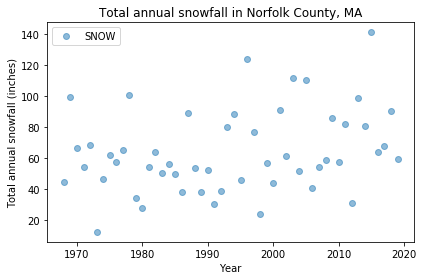

In [174]:
complete.plot(style='o', alpha=0.5)

decorate(xlabel='Year',
         ylabel='Total annual snowfall (inches)',
         title='Total annual snowfall in Norfolk County, MA')

Looking at this plot, it's hard to say whether snowfall is increasing, decreasing, or unchanged.  In the last decade, we've had several years with more snow than 1978, including 2015, which was the snowiest winter in the Boston area in modern history, with a total of 141 inches.

In [175]:
complete.loc[[1978, 1996, 2015]]

YEAR
1978    100.6
1996    124.2
2015    141.1
Name: SNOW, dtype: float64

This kind of question -- looking at noisy data and wondering whether it is going up or down -- is precisely the question we can answer with Bayesian regression.

The foundation of regression (Bayesian or not) is the model that a time series like this is the sum of two parts:

1. A linear function of time, and

2. A series of random values drawn from a distribution that is not changing over time.

Mathematically,

$y = a x + b + \epsilon$

where $y$ is the series of measurements (snowfall in this example), $x$ is the series of times (years) and $\epsilon$ is the series of random values.

$a$ and $b$ are the slope and intercept of the line through the data.  They are unknown parameters, so we will use the data to estimate them.

We don't know the distribution of $\epsilon$, so we'll make the additional assumption that it is a normal distribution with mean 0 and unknown standard deviation, $\sigma$.  To see whether this assumption is reasonable, I'll plot the distribution of total snowfall and a normal model with the same mean and standard deviations.  

In [176]:
pmf_snowfall = Pmf.from_seq(complete)

mean, std = pmf_snowfall.mean(), pmf_snowfall.std()
mean, std

(64.19038461538462, 26.288021984395684)

In [177]:
from scipy.stats import norm

dist = norm(mean, std)
qs = pmf_snowfall.qs
ps = dist.cdf(qs)

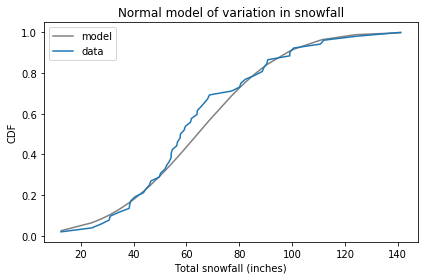

In [178]:
plt.plot(qs, ps, color='gray', label='model')
pmf_snowfall.make_cdf().plot(label='data')

decorate(xlabel='Total snowfall (inches)',
         ylabel='CDF',
         title='Normal model of variation in snowfall')

We've had more winters below the mean than expected, but overall this looks like a reasonable model, particularly in the tails, which are often problematic.

This model has three parameters: slope, intercept, and standard deviation of $\epsilon$.  In the next section we'll see how to compute the likelihood of the data, given these parameters; then we'll see how to estimate them.


In [203]:
data = complete.reset_index()
data.head()

,YEAR,SNOW
0,1968,44.7
1,1969,99.2
2,1970,66.8
3,1971,54.6
4,1972,68.7


In [180]:
offset = data['YEAR'].mean()
offset

1993.5

In [204]:
data['x'] = data['YEAR'] - offset
data['x'].mean()

0.0

In [182]:
import statsmodels.formula.api as smf

formula = 'SNOW ~ x'
results = smf.ols(formula, data=data).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   SNOW   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     4.669
Date:                Fri, 14 Aug 2020   Prob (F-statistic):             0.0355
Time:                        16:14:01   Log-Likelihood:                -241.46
No. Observations:                  52   AIC:                             486.9
Df Residuals:                      50   BIC:                             490.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     64.1904      3.555     18.054      0.000      57.049      71.332
x              0.5119      0.237      2.161      0.036       0.036       0.988
==============================================================================
Omnibus:                        3.736   Durbin-Watson:                   2.290
Prob(Omnibus):                  0.154   Jarque-Bera (JB):                3.257
Skew:                           0.613   Prob(JB):                        0.196
Kurtosis:                       2.978   Cond. No.                         15.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Suppose there is a linear relationship between `x` and `y` with slope 2 and intercept 1, but the measurements of `y` are noisy; specifically, the noise is Gaussian with mean 0 and `sigma = 0.3`. 

In [183]:
inter = 64
slope = 0.51
sigma = 26

In [184]:
xs = data['x']
ys = data['SNOW']

In [185]:
resid = slope * xs + inter - ys
resid.describe()

count    52.000000
mean     -0.190385
std      25.385697
min     -66.135000
25%     -14.125000
50%       6.565000
75%      17.442500
max      42.335000
dtype: float64

In [186]:
densities = norm(0, sigma).pdf(resid)
densities

array([0.01490073, 0.00285242, 0.01305324, 0.01529515, 0.01279708,
       0.0044134 , 0.01470964, 0.01474532, 0.01526593, 0.01426784,
       0.00354561, 0.010655  , 0.00809097, 0.01521138, 0.01494539,
       0.01455552, 0.01525171, 0.01425735, 0.01077026, 0.00837361,
       0.01468642, 0.01030307, 0.01430933, 0.00718604, 0.00993735,
       0.01258966, 0.0098625 , 0.01182567, 0.00117652, 0.0139576 ,
       0.00411173, 0.01420639, 0.01015782, 0.01038433, 0.01482279,
       0.00386994, 0.01221638, 0.00446989, 0.00796445, 0.01248853,
       0.01372076, 0.01330202, 0.01304467, 0.01437819, 0.00407589,
       0.00960892, 0.01492131, 0.00060389, 0.01392   , 0.01463711,
       0.01329929, 0.01226386])

In [187]:
likelihood = densities.prod()
likelihood

1.290411849292259e-105

## Estimation

We can solve the problem first using a grid algorithm, with uniform priors for slope, intercept, and sigma.

As an exercise, fill in this likelihood function, then test it using the code below.

Your results will depend on the random data you generated, but in general you should find that the posterior marginal distributions peak near the actual parameters.

In [293]:
slopes = np.linspace(-0.5, 1.5, 31)
prior_slope = Pmf(1, slopes)
prior_slope.index.name = 'Slope'

In [294]:
inters = np.linspace(55, 75, 31)
prior_inter = Pmf(1, inters)
prior_inter.index.name = 'Intercept'

In [295]:
sigmas = np.linspace(20, 35, 31)
prior_sigma = Pmf(1, sigmas)
prior_sigma.index.name = 'Sigma'

In [296]:
from utils import make_joint

joint2 = make_joint(prior_inter, prior_slope)
joint2.head()

Intercept,55.000000,55.666667,56.333333,57.000000,57.666667,58.333333,59.000000,59.666667,60.333333,61.000000,...,69.000000,69.666667,70.333333,71.000000,71.666667,72.333333,73.000000,73.666667,74.333333,75.000000
Slope,,,,,,,,,,,,,,,,,,,,,
-0.500000,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
-0.433333,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
-0.366667,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
-0.300000,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
-0.233333,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [297]:
prior2 = Pmf(joint2.stack())
prior2.head()

Slope  Intercept
-0.5   55.000000    1
       55.666667    1
       56.333333    1
       57.000000    1
       57.666667    1
dtype: int64

In [298]:
joint3 = make_joint(prior_sigma, prior2)
joint3.head()

Sigma            20.0  20.5  21.0  21.5  22.0  22.5  23.0  23.5  24.0  24.5  \
Slope Intercept                                                               
-0.5  55.000000     1     1     1     1     1     1     1     1     1     1   
      55.666667     1     1     1     1     1     1     1     1     1     1   
      56.333333     1     1     1     1     1     1     1     1     1     1   
      57.000000     1     1     1     1     1     1     1     1     1     1   
      57.666667     1     1     1     1     1     1     1     1     1     1   

Sigma            ...  30.5  31.0  31.5  32.0  32.5  33.0  33.5  34.0  34.5  \
Slope Intercept  ...                                                         
-0.5  55.000000  ...     1     1     1     1     1     1     1     1     1   
      55.666667  ...     1     1     1     1     1     1     1     1     1   
      56.333333  ...     1     1     1     1     1     1     1     1     1   
      57.000000  ...     1     1     1     1     1     1     1     1     1   
      57.666667  ...     1     1     1     1     1     1     1     1     1   

Sigma            35.0  
Slope Intercept        
-0.5  55.000000     1  
      55.666667     1  
      56.333333     1  
      57.000000     1  
      57.666667     1  

[5 rows x 31 columns]

In [299]:
prior3 = Pmf(joint3.stack())
prior3.head()

Slope  Intercept  Sigma
-0.5   55.0       20.0     1
                  20.5     1
                  21.0     1
                  21.5     1
                  22.0     1
dtype: int64

In [300]:
len(prior3)

29791

In [301]:
xs = data['x']
ys = data['SNOW']

In [302]:
likelihood = prior3.copy()

for slope, inter, sigma in prior3.index:
    resid = slope * xs + inter - ys
    densities = norm.pdf(resid, 0, sigma)
    likelihood.loc[slope, inter, sigma] = densities.prod()

In [303]:
likelihood.head()

Slope  Intercept  Sigma
-0.5   55.0       20.0     7.192950e-116
                  20.5     3.868990e-115
                  21.0     1.741017e-114
                  21.5     6.671900e-114
                  22.0     2.211914e-113
dtype: float64

In [304]:
likelihood.sum()

2.068055459698619e-102

In [305]:
posterior3 = prior3 * likelihood
posterior3.normalize()
posterior3.shape

(29791,)

In [306]:
unstacked = posterior3.unstack()
unstacked.head()

Sigma                    20.0          20.5          21.0          21.5  \
Slope Intercept                                                           
-0.5  55.000000  3.478122e-14  1.870835e-13  8.418618e-13  3.226171e-12   
      55.666667  7.494007e-14  3.884553e-13  1.688949e-12  6.268486e-12   
      56.333333  1.524021e-13  7.634196e-13  3.215382e-12  1.158576e-11   
      57.000000  2.925331e-13  1.420045e-12  5.808834e-12  2.036915e-11   
      57.666667  5.299886e-13  2.500099e-12  9.958309e-12  3.406497e-11   

Sigma                    22.0          22.5          23.0          23.5  \
Slope Intercept                                                           
-0.5  55.000000  1.069562e-11  3.110661e-11  8.035427e-11  1.864101e-10   
      55.666667  2.017056e-11  5.704999e-11  1.435767e-10  3.250363e-10   
      56.333333  3.626536e-11  9.996138e-11  2.455758e-10  5.435252e-10   
      57.000000  6.216251e-11  1.673334e-10  4.020808e-10  8.716311e-10   
      57.666667  1.015845e-10  2.676128e-10  6.301844e-10  1.340513e-09   

Sigma                    24.0          24.5  ...          30.5          31.0  \
Slope Intercept                              ...                               
-0.5  55.000000  3.922068e-10  7.550533e-10  ...  1.784583e-08  1.787264e-08   
      55.666667  6.683771e-10  1.259306e-09  ...  2.482464e-08  2.460073e-08   
      56.333333  1.094215e-09  2.020986e-09  ...  3.368522e-08  3.305697e-08   
      57.000000  1.720910e-09  3.120859e-09  ...  4.458680e-08  4.336442e-08   
      57.666667  2.600091e-09  4.637283e-09  ...  5.756832e-08  5.553411e-08   

Sigma                    31.5          32.0          32.5          33.0  \
Slope Intercept                                                           
-0.5  55.000000  1.743164e-08  1.659120e-08  1.543925e-08  1.407136e-08   
      55.666667  2.375349e-08  2.239237e-08  2.064775e-08  1.865459e-08   
      56.333333  3.162286e-08  2.954750e-08  2.701572e-08  2.421133e-08   
      57.000000  4.113008e-08  3.811883e-08  3.458262e-08  3.076344e-08   
      57.666667  5.226399e-08  4.807912e-08  4.331085e-08  3.826788e-08   

Sigma                    33.5          34.0          34.5          35.0  
Slope Intercept                                                          
-0.5  55.000000  1.258052e-08  1.104969e-08  9.547227e-09  8.124951e-09  
      55.666667  1.653942e-08  1.441129e-08  1.235693e-08  1.043941e-08  
      56.333333  2.130092e-08  1.842353e-08  1.568597e-08  1.316248e-08  
      57.000000  2.687402e-08  2.308663e-08  1.952897e-08  1.628569e-08  
      57.666667  3.321417e-08  2.835734e-08  2.384594e-08  1.977338e-08  

[5 rows x 31 columns]

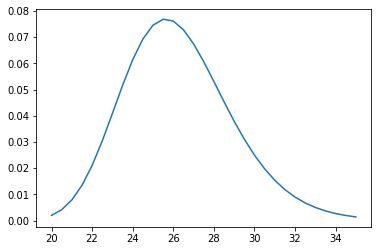

In [307]:
from utils import marginal

posterior_sigma = marginal(unstacked, 0)
posterior_sigma.plot()

In [308]:
posterior2 = marginal(unstacked, 1)
posterior2.head()

Slope  Intercept
-0.5   55.000000    2.417800e-07
       55.666667    3.373220e-07
       56.333333    4.602445e-07
       57.000000    6.137779e-07
       57.666667    7.996044e-07
dtype: float64

In [309]:
joint_posterior = posterior2.unstack().transpose()
joint_posterior.head()

Slope,-0.500000,-0.433333,-0.366667,-0.300000,-0.233333,-0.166667,-0.100000,-0.033333,0.033333,0.100000,...,0.900000,0.966667,1.033333,1.100000,1.166667,1.233333,1.300000,1.366667,1.433333,1.500000
Intercept,,,,,,,,,,,,,,,,,,,,,
55.000000,2.417800e-07,5.570113e-07,0.000001,0.000003,0.000005,0.000010,0.000019,0.000034,0.000057,0.000089,...,0.000103,0.000067,0.000041,0.000024,0.000013,0.000007,0.000003,0.000002,7.431272e-07,3.269255e-07
55.666667,3.373220e-07,7.833851e-07,0.000002,0.000004,0.000008,0.000015,0.000028,0.000050,0.000084,0.000133,...,0.000155,0.000100,0.000061,0.000035,0.000019,0.000010,0.000005,0.000002,1.048209e-06,4.574037e-07
56.333333,4.602445e-07,1.077162e-06,0.000002,0.000005,0.000011,0.000022,0.000041,0.000073,0.000123,0.000195,...,0.000227,0.000146,0.000088,0.000050,0.000027,0.000014,0.000007,0.000003,1.445375e-06,6.257868e-07
57.000000,6.137779e-07,1.447144e-06,0.000003,0.000007,0.000015,0.000030,0.000057,0.000102,0.000174,0.000278,...,0.000323,0.000207,0.000124,0.000070,0.000038,0.000019,0.000009,0.000004,1.947072e-06,8.367157e-07
57.666667,7.996044e-07,1.898467e-06,0.000004,0.000010,0.000020,0.000040,0.000077,0.000140,0.000239,0.000385,...,0.000449,0.000285,0.000170,0.000096,0.000051,0.000026,0.000013,0.000006,2.560813e-06,1.092716e-06


In [310]:
def plot_contour(joint, **options):
    """Plot a joint distribution.
    
    joint: DataFrame representing a joint PMF
    """
    cs = plt.contour(joint.columns, joint.index, joint, **options)
    decorate(xlabel=joint.columns.name, 
             ylabel=joint.index.name)
    return cs

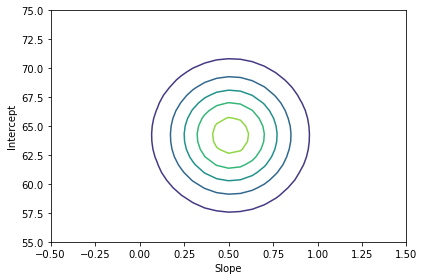

In [311]:
plot_contour(joint_posterior)

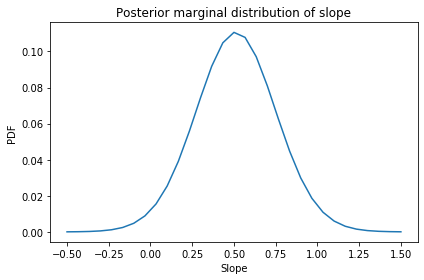

In [312]:
posterior_slope = marginal(joint_posterior, 0)

posterior_slope.plot()
decorate(xlabel='Slope',
         ylabel='PDF',
         title='Posterior marginal distribution of slope')

In [313]:
posterior_slope.mean(), posterior_slope.credible_interval(0.9)

(0.5118684538574172, array([0.1, 0.9]))

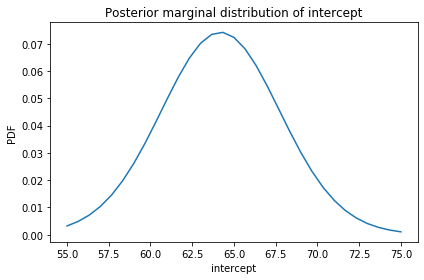

In [314]:
posterior_inter = marginal(joint_posterior, 1)

posterior_inter.plot()
decorate(xlabel='intercept',
         ylabel='PDF',
         title='Posterior marginal distribution of intercept')

In [315]:
posterior_inter.mean(), posterior_inter.credible_interval(0.9)

(64.22861083706859, array([58.33333333, 70.33333333]))

## GSS data

Another example using data from the [General Social Survey](https://gss.norc.org/) ...


In [37]:
# Load the data file

# TODO: Update this to point to the ThinkBayes2 repo

import os

datafile = 'gss_eda.hdf5'
if not os.path.exists(datafile):
    !wget https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/master/gss_eda.hdf5

In [38]:
gss = pd.read_hdf(datafile, 'gss')
gss.shape

(64814, 169)

In [40]:
gss.groupby('year')['realrinc'].max()

year
1972              NaN
1973              NaN
1974     96450.000000
1975     75863.000000
1976     81652.000000
1977    201640.000000
1978    135131.000000
1980    139297.000000
1982     97992.000000
1983     81266.000000
1984     87058.000000
1985     96036.000000
1986    101376.000000
1987     92594.000000
1988     83666.000000
1989     80690.000000
1990    103206.000000
1991    111284.000000
1993    123611.000000
1994     97684.000000
1996     87419.000000
1998    150054.000000
2000    134018.000000
2002    234366.656250
2004    134008.437500
2006    159292.265625
2008    480144.468750
2010    109525.156250
2012    341672.375000
2014    132148.078125
2016    164382.031250
2018    151050.718750
Name: realrinc, dtype: float32

In [41]:
gss['rincome'].value_counts()

12.0    14957
9.0      4876
11.0     3838
10.0     3838
2.0      1865
8.0      1745
1.0      1306
3.0      1243
5.0      1091
4.0      1055
6.0       993
7.0       981
Name: rincome, dtype: int64

In [42]:
valid = gss.dropna(subset=['rincome', 'realinc'])
valid.shape

(36916, 169)

2000


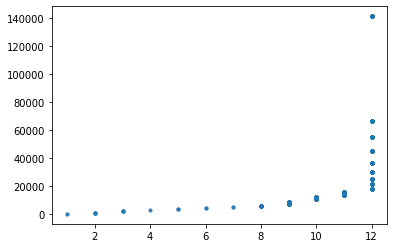

In [50]:
for name, group in valid.groupby('year'):
    if name == 2000:
        print(name)
        plt.plot(group['income'], group['realinc'], '.', alpha=0.3)

In [ ]:
valid = gss.dropna(subset=['realinc', 'polviews'])
valid.shape

In [ ]:
plt.plot(valid['realinc'], valid['polviews'], ',', alpha=0.3)

## Marathon world record

In [155]:
url = 'https://en.wikipedia.org/wiki/Marathon_world_record_progression#Men'
tables = pd.read_html(url)
len(tables)

5

In [156]:
table = tables[0]
table.head()

,Time,Name,Nationality,Date,Event/Place,Source,Notes
0,2:55:18.4,Johnny Hayes,United States,"July 24, 1908","London, United Kingdom",IAAF[53],Time was officially recorded as 2:55:18 2/5.[5...
1,2:52:45.4,Robert Fowler,United States,"January 1, 1909","Yonkers,[nb 5] United States",IAAF[53],Note.[56]
2,2:46:52.8,James Clark,United States,"February 12, 1909","New York City, United States",IAAF[53],Note.[56]
3,2:46:04.6,Albert Raines,United States,"May 8, 1909","New York City, United States",IAAF[53],Note.[56]
4,2:42:31.0,Henry Barrett,United Kingdom,"May 26, 1909[nb 6]","Polytechnic Marathon, London, United Kingdom",IAAF[53],Note.[56]


In [157]:
table['date'] = pd.to_datetime(table['Date'], errors='coerce')
table['date']

0    1908-07-24
1    1909-01-01
2    1909-02-12
3    1909-05-08
4           NaT
5    1909-08-31
6    1913-05-12
7    1913-05-31
8    1914-11-29
9    1920-08-22
10   1925-10-12
11   1929-07-05
12   1935-03-21
13   1935-03-31
14   1935-04-03
15   1935-11-03
16   1947-04-19
17   1952-06-14
18   1953-06-13
19   1953-10-04
20   1954-06-26
21   1956-08-12
22   1958-08-24
23   1960-09-10
24   1963-02-17
25   1963-06-15
26   1963-07-06
27   1964-06-13
28   1964-10-21
29   1965-06-12
30   1967-12-03
31   1969-05-30
32   1970-07-23
33   1974-01-31
34   1978-02-05
35   1980-04-26
36   1981-12-06
37   1984-10-21
38   1985-04-20
39   1988-04-17
40   1998-09-20
41   1999-10-24
42   2002-04-14
43   2003-09-28
44   2007-09-30
45   2008-09-28
46   2011-09-25
47   2013-09-29
48   2014-09-28
49   2018-09-16
Name: date, dtype: datetime64[ns]

In [158]:
table['date'].dt

In [159]:
table['time'] = pd.to_timedelta(table['Time'])

In [160]:
table['mph'] = 26.2 / table['time'].dt.total_seconds() * 3600
table['mph']

0      8.967143
1      9.099504
2      9.419942
3      9.465508
4      9.672854
5      9.790123
6      9.932394
7     10.069823
8      9.948528
9     10.301667
10    10.548212
11    10.413355
12    10.749943
13    10.634795
14    10.713312
15    10.715746
16    10.792997
17    11.172443
18    11.335993
19    11.343628
20    11.419716
21    11.384705
22    11.620057
23    11.621202
24    11.621775
25    11.690630
26    11.668935
27    11.738643
28    11.892274
29    11.909091
30    12.129006
31    12.227754
32    12.140871
33    12.167183
34    12.177236
35    12.184472
36    12.252533
37    12.273260
38    12.358491
39    12.394218
40    12.467944
41    12.505967
42    12.512603
43    12.584390
44    12.633271
45    12.679124
46    12.715018
47    12.740781
48    12.785685
49    12.922318
Name: mph, dtype: float64

In [161]:
def plot_speeds(df):
    plt.axhline(13.1, color='gray')
    plt.plot(df['date'], df['mph'], 'o', alpha=0.5)
    
    decorate(xlabel='Date',
             ylabel='Speed (mph)')

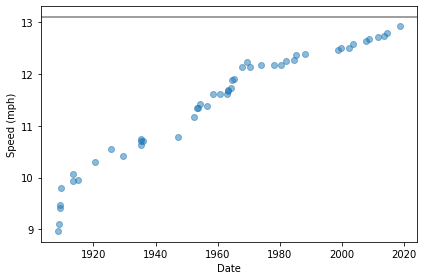

In [162]:
plot_speeds(table)

In [163]:
recent = table['date'] > pd.to_datetime('1970')

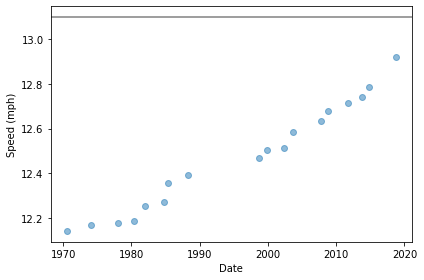

In [164]:
data = table.loc[recent].copy()
plot_speeds(data)

In [165]:
offset = pd.to_datetime('1995')
timedelta = table['date'] - offset
data['x'] = timedelta.dt.total_seconds() / 3600 / 24 / 365.24
data['x'].describe()

count    18.000000
mean      0.740913
std      15.417918
min     -24.444201
25%     -12.352152
50%       4.264319
75%      13.492498
max      23.707699
Name: x, dtype: float64

In [166]:
import statsmodels.formula.api as smf

formula = 'mph ~ x'
results = smf.ols(formula, data=data).fit()
results.summary()

/home/downey/anaconda3/envs/ThinkBayes2/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mph   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     530.7
Date:                Sat, 01 Aug 2020   Prob (F-statistic):           1.07e-13
Time:                        14:02:51   Log-Likelihood:                 32.294
No. Observations:                  18   AIC:                            -60.59
Df Residuals:                      16   BIC:                            -58.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.4605      0.010   1237.317      0.000      12.439      12.482
x              0.0155      0.001     23.037      0.000       0.014       0.017
==============================================================================
Omnibus:                        1.748   Durbin-Watson:                   1.101
Prob(Omnibus):                  0.417   Jarque-Bera (JB):                1.174
Skew:                           0.612   Prob(JB):                        0.556
Kurtosis:                       2.745   Cond. No.                         15.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [167]:
slopes = np.linspace(0.01, 0.02, 51)
prior_slope = Pmf(1, slopes)
prior_slope.index.name = 'Slope'

In [168]:
inters = np.linspace(12.4, 12.6, 41)
prior_inter = Pmf(1, inters)
prior_inter.index.name = 'Intercept'

In [169]:
sigmas = np.linspace(0.01, 0.31, 31)
prior_sigma = Pmf(1, sigmas)
prior_sigma.index.name = 'Sigma'

In [170]:
joint = make_joint(prior_slope, prior_inter)
joint.shape

(41, 51)

In [171]:
joint_pmf = Pmf(joint.transpose().stack())
joint_pmf.head()

Slope  Intercept
0.01   12.400       1
       12.405       1
       12.410       1
       12.415       1
       12.420       1
dtype: int64

In [172]:
prior3 = make_joint(prior_sigma, joint_pmf)
prior3.shape

(2091, 31)

In [173]:
from scipy.stats import norm

xs = data['x']
ys = data['mph']

likelihood = prior3.copy()

for (slope, inter), sigmas in prior3.iterrows():
    resid = slope * xs + inter - ys
    sigma_mesh, resid_mesh = np.meshgrid(prior_sigma.index, resid)
    densities = norm.pdf(resid_mesh, 0, sigma_mesh)
    like = densities.prod(axis=0)
    likelihood.loc[slope, inter] = like

In [174]:
from utils import normalize

posterior3 = prior3 * likelihood
normalize(posterior3)
posterior3.shape

(2091, 31)

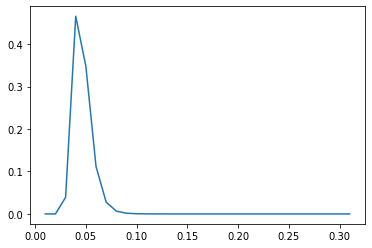

In [175]:
from utils import marginal

posterior_sigma = marginal(posterior3, 0)
posterior_sigma.plot()

In [176]:
posterior_pmf = marginal(posterior3, 1)
posterior_pmf.shape

(2091,)

In [177]:
posterior_joint = posterior_pmf.unstack().transpose()
posterior_joint.shape

(41, 51)

In [178]:
def plot_contour(joint, **options):
    """Plot a joint distribution.
    
    joint: DataFrame representing a joint PMF
    """
    cs = plt.contour(joint.columns, joint.index, joint, **options)
    decorate(xlabel=joint.columns.name, 
             ylabel=joint.index.name)
    return cs

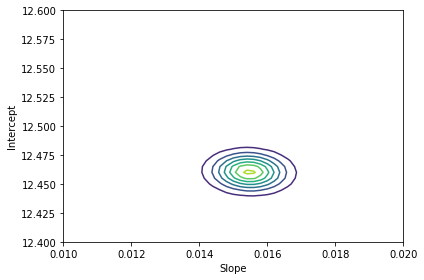

In [179]:
plot_contour(posterior_joint)

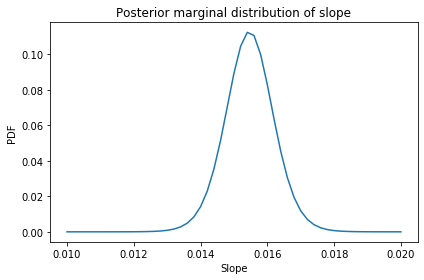

In [180]:
posterior_slope = marginal(posterior_joint, 0)

posterior_slope.plot()
decorate(xlabel='Slope',
         ylabel='PDF',
         title='Posterior marginal distribution of slope')

In [181]:
posterior_slope.mean(), posterior_slope.credible_interval(0.9)

(0.015464394668292185, array([0.0142, 0.0166]))

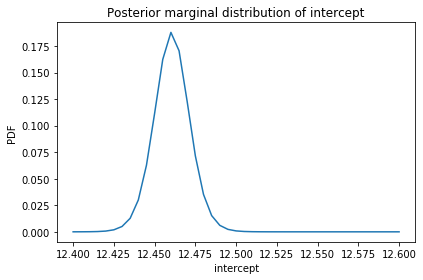

In [182]:
posterior_inter = marginal(posterior_joint, 1)

posterior_inter.plot()
decorate(xlabel='intercept',
         ylabel='PDF',
         title='Posterior marginal distribution of intercept')

In [183]:
posterior_inter.mean(), posterior_inter.credible_interval(0.9)

(12.460507580847914, array([12.44, 12.48]))

In [184]:
posterior_pmf = Pmf(posterior3.stack())
posterior_pmf.head()

Slope  Intercept  Sigma
0.01   12.4       0.01      0.000000e+00
                  0.02     2.651660e-115
                  0.03      1.140654e-50
                  0.04      3.462615e-29
                  0.05      6.013886e-20
dtype: float64

In [185]:
sample = posterior_pmf.sample(101)
xs = np.arange(-25, 50, 2)
pred = np.empty((len(sample), len(xs)))

for i, (slope, inter, sigma) in enumerate(sample):
    pred[i] = inter + slope * xs + norm(0, sigma).rvs(len(xs))
    
pred.shape

(101, 38)

In [187]:
low, median, high = np.percentile(pred, [5, 50, 95], axis=0)
median.shape

(38,)

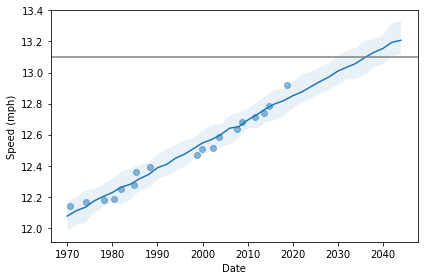

In [190]:
times = pd.to_timedelta(xs*365.24, unit='days') + offset

plt.fill_between(times, low, high, alpha=0.1)
plt.plot(times, median, color='C0')

plot_speeds(data)

In [189]:
from scipy.interpolate import interp1d

future = np.array([interp1d(high, xs)(13.1),
                   interp1d(median, xs)(13.1),
                   interp1d(low, xs)(13.1)])

pd.to_timedelta(future*365.24, unit='day') + offset

DatetimeIndex([   '2029-08-10 15:41:20.272704',
               '2036-03-17 10:24:35.436758400',
               '2041-10-08 03:04:39.181468800'],
              dtype='datetime64[ns]', freq=None)

## Exercises


**Exercise:** Is temperature increasing?

In [83]:
temp = df.groupby('year')['TMAX'].mean()
len(temp)

54

In [84]:
complete_temp = temp.iloc[1:-1]
len(complete_temp)

52

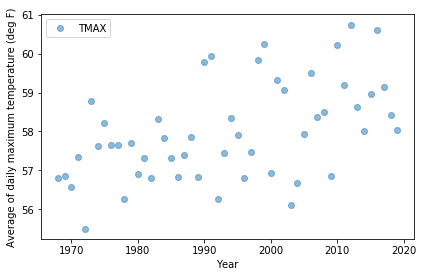

In [86]:
complete_temp.plot(style='o', alpha=0.5)

decorate(xlabel='Year',
         ylabel='Average of daily maximum temperature (deg F)')